In [1]:
from Toy_Datasets.Toy_Datasets import two_clusters_gaussian, plot_decision_boundary, plot_uncertainty
from Toy_Datasets.Toy_Datasets_2D import create_two_circular_classes_outer
from Neural_Network import NLM,Classifier
import autograd.numpy as np
from sklearn.linear_model import LogisticRegression
from autograd import grad
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from sklearn.model_selection import train_test_split
from pandas import get_dummies
from Entropy import  epistemic_uncertainty, expected_aleatoric_uncertainty, total_uncertainty

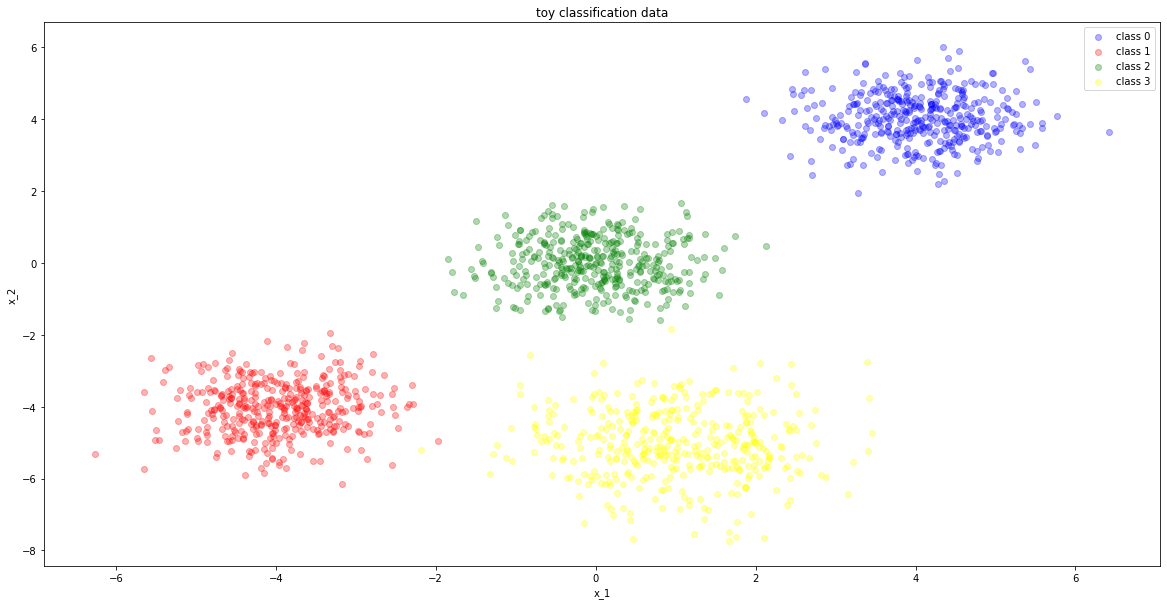

In [2]:
params_1 = {'mean': [4, 4], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-4, -4], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params_4 = {'mean': [1, -5], 'covariance_matrix': 1 * np.eye(2)}

params = [params_1, params_2,params_3,params_4]
#params = [params_1, params_2,params_3]

x, y = two_clusters_gaussian(params, 400)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')
ax.scatter(x[y == 3, 0], x[y == 3, 1], alpha=0.3, color='yellow', label='class 3')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# NLM

In [4]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)
y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)

In [5]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':100, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)


y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nlm.fit_MLE(X_train.T, y_train.T, params)

#import pickle
#filename = 'weights50000'
#f=open(filename,"wb" )
#pickle.dump(nlm.weights,f)
#f.close()

Iteration 0 lower bound 1.904633367160931; gradient mag: 5.826386362729399


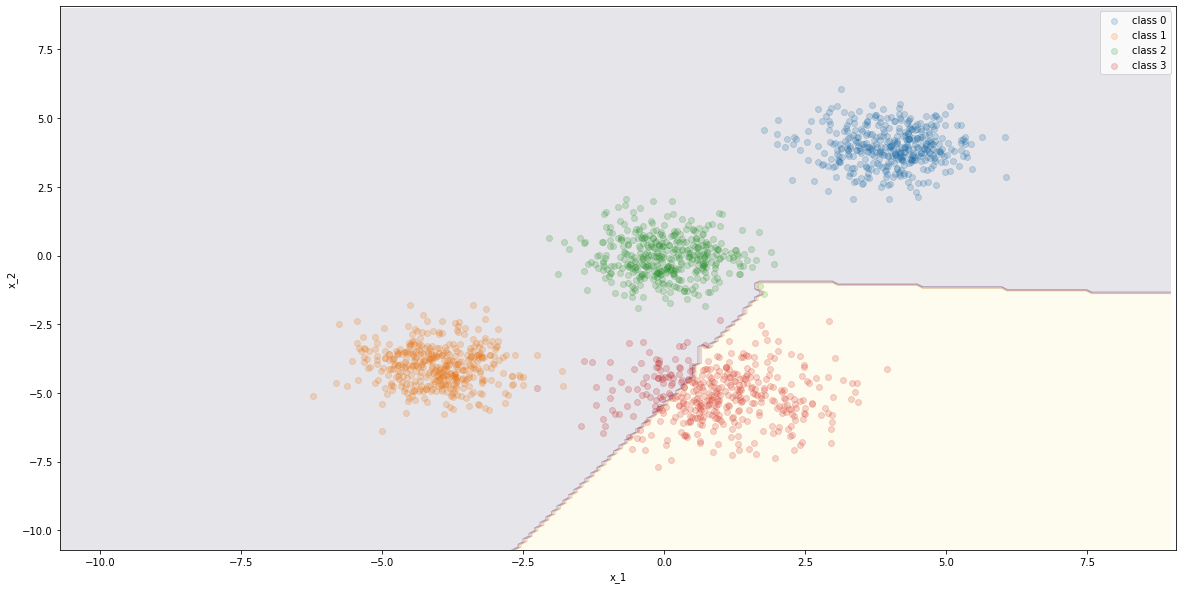

In [6]:
classifier = [Classifier(nlm.weights, nlm.forward)]
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, classifier, ax)
plt.show()

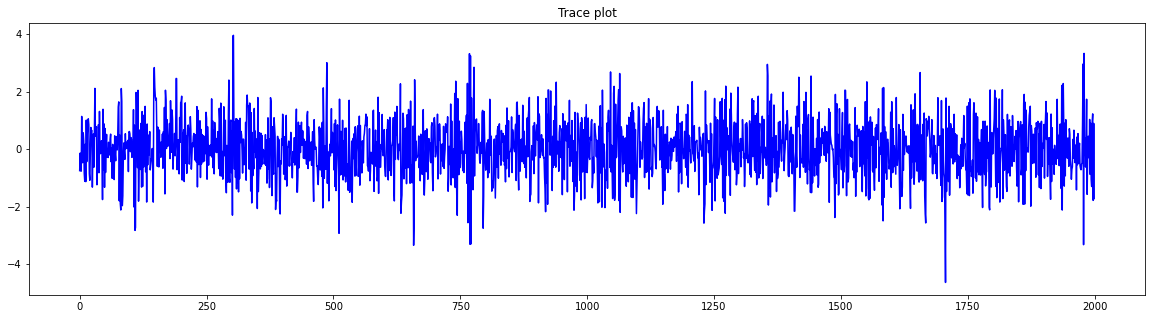

In [62]:
w_0=[]
w_1=[]
w_2=[]
for i in range(len(traces['w'])):    
    w_0.append(traces['w'][i][-4])        
    w_1.append(traces['w'][i][1])        
    w_2.append(traces['w'][i][2])
    
fig, ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(range(len(w_0)), w_0, color='b')
ax.set_title('Trace plot')
plt.show()

In [7]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':100, 
          'random_restarts':1}

import autograd.numpy as np
from pymc3 import Model
import pymc3 as pm
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
mac=True

models=nlm.sample_models(X_train.T, y_train.T, params, 100, mac)

Currently fitting a Neural Network for the Classification task
Iteration 0 lower bound 1.2560721309854637; gradient mag: 1.2619370266707726
NN trained ! Now, thanks to the feature map, we are going to sample the posterior weights


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, models, ax)
plt.show()

In [ ]:
def plot_uncertainty(x, y, models, ax, func):
    # Plot data
    # from one-hot encode to array
    if y.shape[1] > 1:
        y = np.argmax(y, axis=1).flatten()
    num_classes = np.max(y) + 1
    for k in range(num_classes):
        ax.scatter(x[y == k, 0], x[y == k, 1], alpha=0.2, label='class ' + str(k))
    # Create mesh
    xmin = np.min(x.flatten()) - 3
    xmax = np.max(x.flatten()) + 3
    interval = np.arange(xmin, xmax, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    alpha_line = 0.8
    linewidths = 0.5

    
    i = 0

    for model in models:
        yy = model.predict(xx)
        yy = np.array([func(x, models) for x in xx])
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
    
        ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1) ** 2, cmap='inferno')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        i += 1


    ax.set_xlim((xmin, xmax))
    ax.set_ylim((xmin, xmax))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax


fig, axes = plt.subplots(1, 3, figsize=(30, 10))
plot_uncertainty(x, y_, models, axes[0], epistemic_uncertainty)
plot_uncertainty(x, y_, models, axes[1], total_uncertainty)
plot_uncertainty(x, y_, models, axes[2], expected_aleatoric_uncertainty)
plt.show()

# New datasets

# Concentric

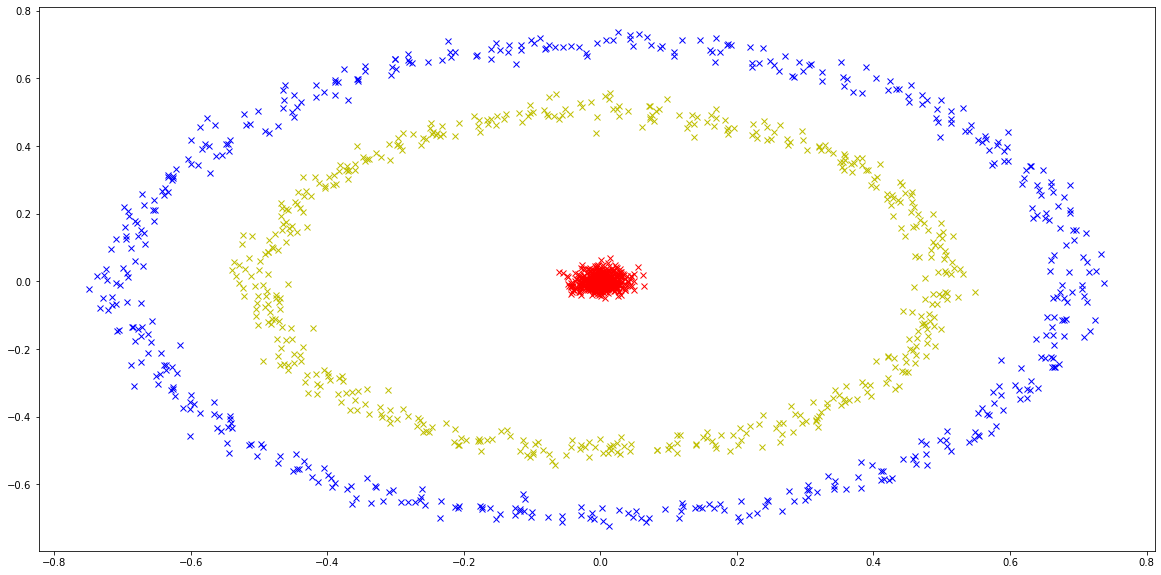

In [3]:
boundary, class1, class2=create_two_circular_classes_outer(n=1000, noise_input=0.02, plot=True, distance=1)

In [4]:
X_try=np.hstack((boundary, class1, class2)).T
y_try= np.array([[k] * 500 for k in range(3)])
y_try=np.array(y_try).flatten()
print(X_try.shape,y_try.shape)

(1500, 2) (1500,)


In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm2 = NLM(architecture, random=random)
y_try_ = get_dummies(y_try).values
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(X_try,y_try_, train_size=0.9, random_state=random)

In [92]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':50000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)

nlm2.fit_MLE(X_train_try.T, y_train_try.T, params)

import pickle
filename = 'weights50000_concentric_3'
f=open(filename,"wb" )
pickle.dump(nlm2.weights,f)
f.close()

Iteration 0 lower bound 1.4388260906777568; gradient mag: 0.9553943694364512
Iteration 100 lower bound 1.2699793553239949; gradient mag: 0.3814414879295451
Iteration 200 lower bound 1.1701121870171498; gradient mag: 0.28302945153954234
Iteration 300 lower bound 1.1032887945659182; gradient mag: 0.22157908179200397
Iteration 400 lower bound 1.0601648264281638; gradient mag: 0.1888171575220183
Iteration 500 lower bound 1.0209083760962414; gradient mag: 0.16078625935219681
Iteration 600 lower bound 0.9693253797079932; gradient mag: 0.15089253421454538
Iteration 700 lower bound 0.9301205706730787; gradient mag: 0.11055523617201526
Iteration 800 lower bound 0.8913671295523435; gradient mag: 0.09631477915543099
Iteration 900 lower bound 0.8376647788707753; gradient mag: 0.12147622572987787
Iteration 1000 lower bound 0.7365151204944455; gradient mag: 0.1610245252420737
Iteration 1100 lower bound 0.6042107903622924; gradient mag: 0.1836392055310001
Iteration 1200 lower bound 0.4440123798294296

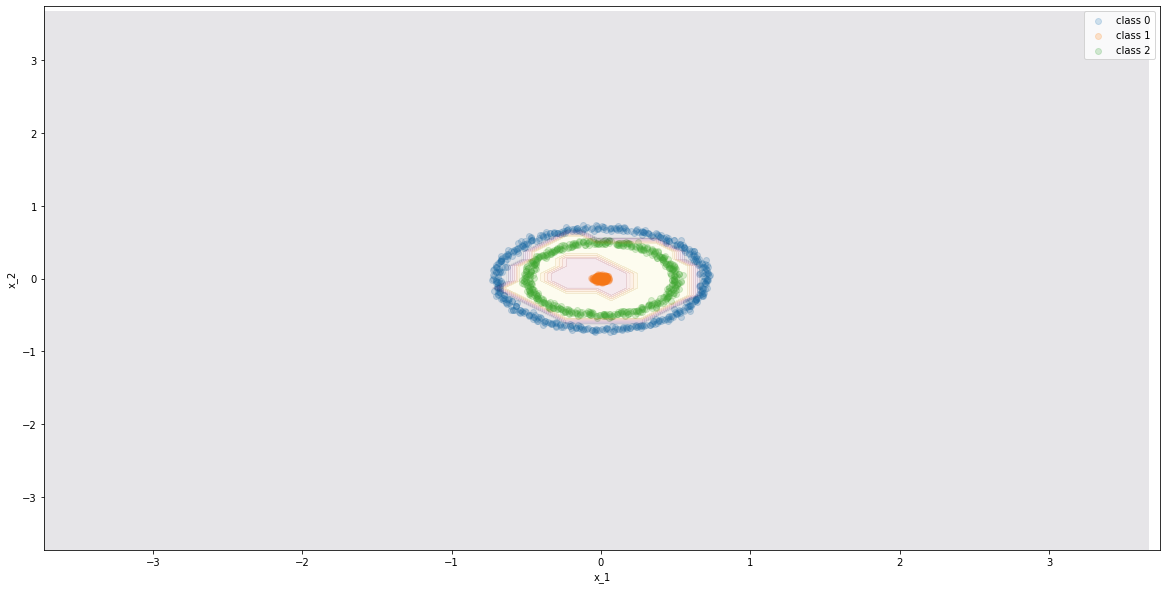

In [93]:
classifier2 = [Classifier(nlm2.weights, nlm2.forward)]
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(X_try, y_try_, classifier2, ax)
plt.show()

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':100, 
          'random_restarts':1}
mac=True
models2=nlm2.sample_models(X_train_try.T, y_train_try.T, params, 50, mac)

Currently fitting a Neural Network for the Classification task
Iteration 0 lower bound 1.5375825392416285; gradient mag: 0.9530566094103119
NN trained ! Now, thanks to the feature map, we are going to sample the posterior weights


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,630.9:   7%|▋         | 13591/200000 [00:27<06:08, 505.78it/s]

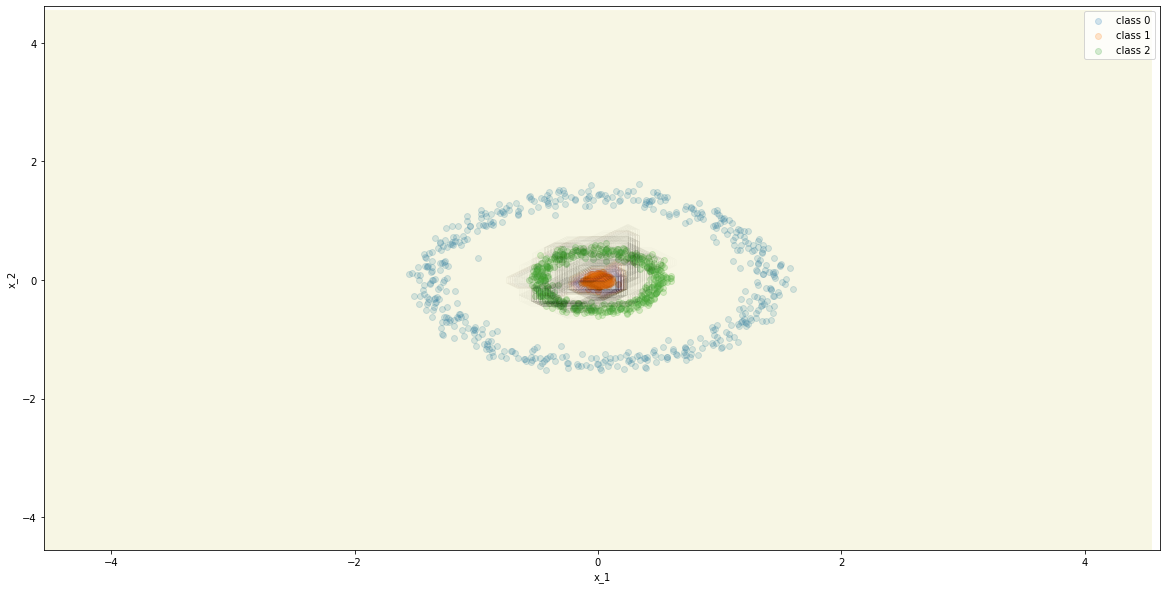

In [22]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(X_try, y_try_, models2, ax)
plt.show()

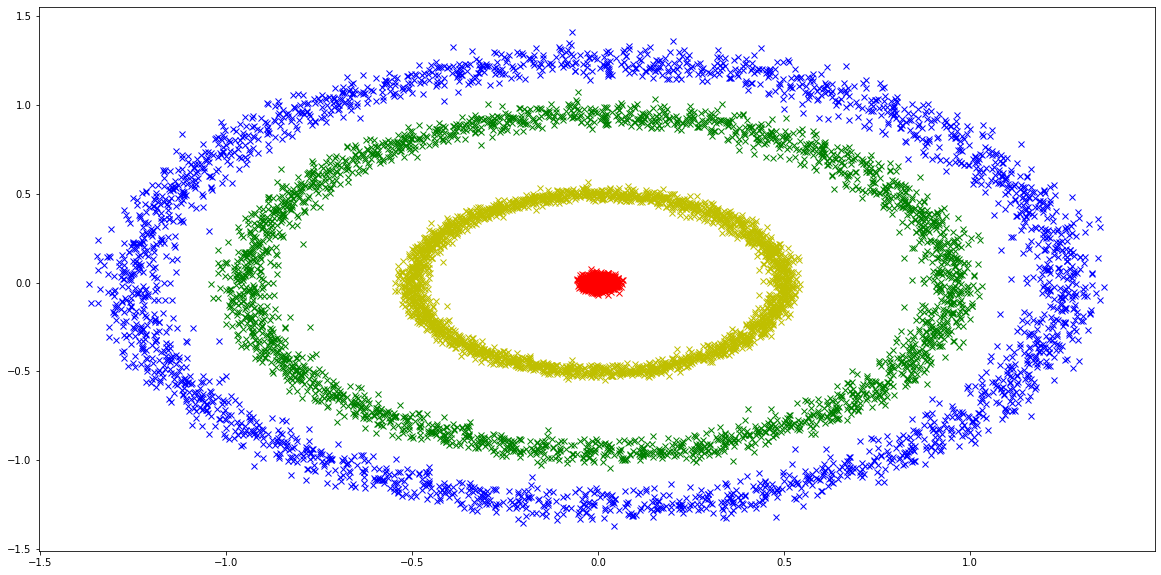

In [11]:
boundary, class1, class2, class3=create_three_circular_classes_outer(n=5000, noise_input=0.02, plot=True, distance=1)

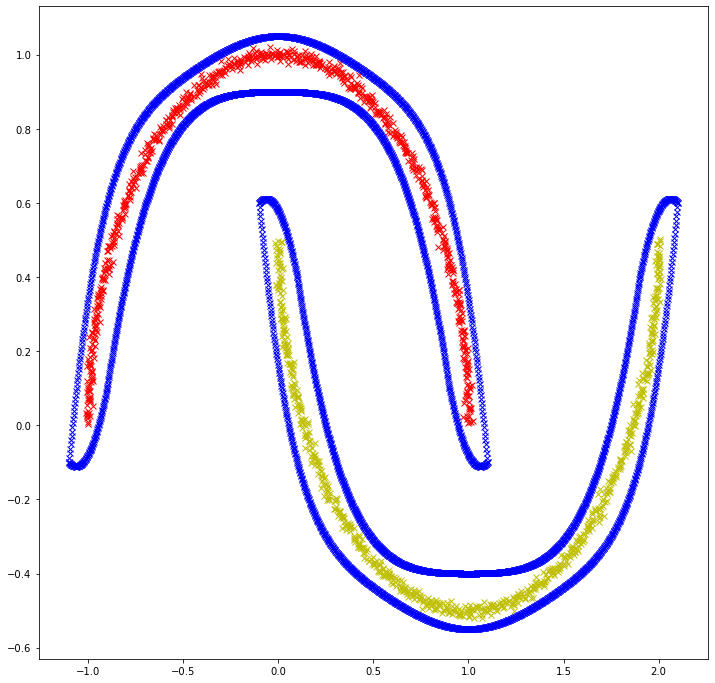

In [14]:
boundary, class1, class2=two_moon(n = 1500, noise_input=.01, plot=True)

# test BNN
* 4 classes
* output dim = 4
* batch = 200

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)
y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nn.fit(X_train.T, y_train.T, params)

#print(y_)
#X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
#nlm.fit_MLE(X_train.T, y_train.T, params)

In [ ]:
#print(nn.forward(nn.weights,x.T)[0][0][:100],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][100:200],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][200:],'\n')
print(nn.forward(nn.weights,x.T))

In [ ]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, D_bayes)).T - (nn.forward(W, x.T)))**2, axis=1).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)

#log_likelihood(nn.weights)


In [13]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def HMC_Unit_test():
    # Generate a toy dataset for classification
    samples = 100
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * 100 + [1] * 100)
    mean = np.zeros(3)
    cov = 10*np.eye(3)
    D = 3

    def log_likelihood(w):
        theta = sigmoid(w[-1] + np.dot(x, w[:-1]))
        return np.sum(np.log(theta[y==1])) + np.sum(np.log(1 - theta[y==0]))

    def log_normal_prior(W):
        logprior = -0.5 * (np.log(np.linalg.det(cov)) + D * np.log(2 * np.pi))
        logprior += -0.5 * np.dot(np.dot(W-mean, np.linalg.inv(cov)), (W-mean).T)
        return logprior
    
    log_prior = log_normal_prior
    log_likelihood = log_likelihood
    lr = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    lr.fit(x, y)
    position_init = np.hstack((lr.coef_.flatten(), lr.intercept_))
    position_init = position_init.reshape((1, 3))[0]
    samples = hmc(log_prior, log_likelihood, 1000,  1e-1, 20, position_init, 0.1, 1)
    q_=np.asarray(samples).T
    plt.plot(range(len(q_[0])),q_[0] , color='r')
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(q_[0], lags=50)
    plt.show()
    #print(log_likelihood(position_init))
    return samples


100 : 0.69
200 : 0.68
300 : 0.6933333333333334
400 : 0.685
500 : 0.674
600 : 0.675
700 : 0.67
800 : 0.665
900 : 0.6688888888888889


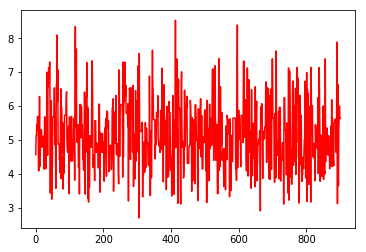

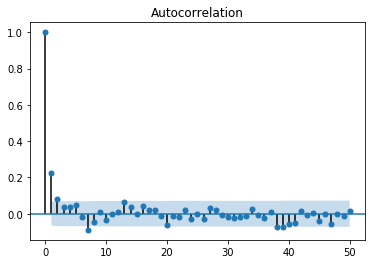

In [14]:
samples=HMC_Unit_test()

Text(0.5, 1.0, 'toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')

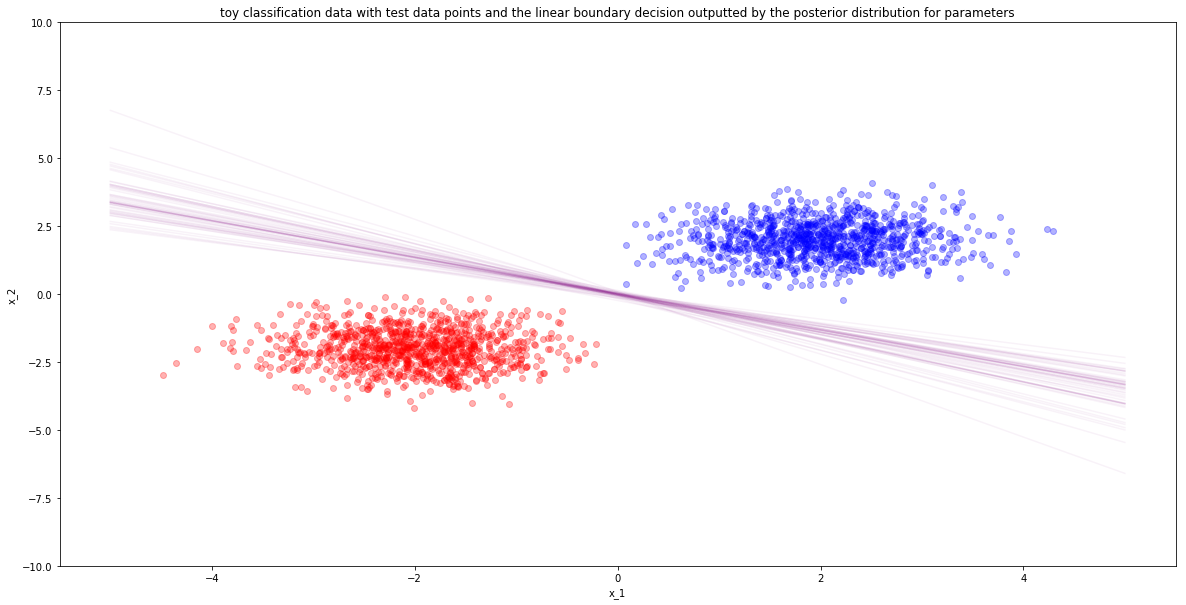

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for sample in samples:
    slope = lambda x :  -sample[1]/sample[0]*x - sample[2]/sample[0]
    if np.random.uniform()< 0.05:
        ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', alpha=0.05)
ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', label='Linear Boundary', alpha=0.2)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')

#for i in range(len(test_points)):
#    pt = test_points[i]
#    if i == 0:
#        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#    else:
        #ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_ylim(-10, 10)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')
